In [3]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [5]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import urllib
from PIL import Image

In [6]:
PATH = 'data/tawkify/'
image_folder = f'{PATH}train/'
data_csv = PATH+'tw_dem_images.csv'
image_csv = PATH+'image_csv.csv'

### Load Data

In [176]:
# df = pd.read_csv(PATH+'Photo_Income_Age_2.8.18.csv')
df = pd.read_csv(data_csv, dtype={'local_photo': 'object', 'image_type': 'object'})

In [230]:
uid = 923214
row = df.loc[df.userID == uid].iloc[0]

In [231]:
row

userID                                                          923214
gender                                                          female
attractedToGender                                                 male
fromState                                                           GA
metro_name                                                         NaN
User_Age                                                            32
User_Photo           https://s3-us-west-1.amazonaws.com/tawkifyfile...
User_Income                                                          0
local_photo                          data/tawkify/corrupted/923214.jpg
image_type                                                   corrupted
Name: 43148, dtype: object

In [200]:
df.loc[row.name]
df.at[row.name, 'image_type'] = 'corrupted'

In [228]:

#     img = img_df.at[idx, 'local_photo']
#     if img == 'corrupted':
#         return
#     print(img)
#     if len(plt.imread(img).shape) >= 3:
#         print('Not bad file:', img)
#         return

corrupted_ids = [923214]
for uid in corrupted_ids:
    row = df.loc[df.userID == uid].iloc[0]
    
    file = row.local_photo
    shape = plt.imread(file).shape
    if len(shape) == 3:
        continue
    print(file)
    corrupted_file = file.replace('train', 'corrupted')
    df.at[row.name, 'local_photo'] = corrupted_file
    df.at[row.name, 'image_type'] = 'corrupted'
    try:
        os.rename(file, corrupted_file)
    except Exception as e:
        pass

data/tawkify/train/923214.jpg


### Explore Data

In [ ]:
df.columns

In [ ]:
df['userID'].size

In [ ]:
df.head()

In [ ]:
df.loc[df.userID == 922512].image_type.isna()

### Download images

In [17]:
from concurrent.futures import ThreadPoolExecutor, wait, as_completed
from time import sleep

a = df.loc[(df.local_photo == '') | df.local_photo.isna()]
print(df.shape)
print(a.shape)

# TEST
a = a[:10000]
chunk_size = 1000
futures = []
# b = a.copy()

(102865, 10)
(1000, 10)


In [12]:
def download_images(df):
    downloaded_images = {}
    failed_images = []
#     sleep(10)
#     return {}, []
    for index, row in df.iterrows():
        if df.index.name == 'userID':
            user_id = index
        else:
            user_id = row['userID']
        image_url = row['User_Photo']
        image_path = f'{image_folder}{user_id}.jpg'
        if os.path.exists(image_path):
            downloaded_images[user_id] = image_path
            continue
        try:
            urllib.request.urlretrieve(image_url, image_path)
            downloaded_images[user_id] = image_path
#                 df['local_photo'][index] = image_path
        except Exception as e:
#             print('Could not download image for user:', user_id)
            failed_images.append(user_id)
            continue
    return downloaded_images, failed_images


In [13]:
with ThreadPoolExecutor(5) as executor:
    for chunk in range(chunk_size, a.shape[0], chunk_size):
        idx_end = max(a.shape[0], chunk+chunk_size)
        futures.append(executor.submit(download_images, a[chunk:idx_end]))

    kwargs = {
        'total': len(futures),
        'unit': 'nap',
        'unit_scale': True,
        'leave': True,
        'disable': False
    }
    for x in tqdm(as_completed(futures), **kwargs):
        dl_imgs, failed = x.result()
        update_df = pd.DataFrame({'userID': list(dl_imgs.keys()), 'local_photo': list(dl_imgs.values())})
        if update_df.index.name != 'userID':
            update_df.set_index('userID', inplace=True)
        if df.index.name != 'userID':
            df.set_index('userID', inplace=True)
        df.update(update_df)
        
        failed_df = pd.DataFrame({'userID': list(failed), 'local_photo': 'corrupted', 'image_type': 'corrupted'})
        if failed_df.index.name != 'userID':
            failed_df.set_index('userID', inplace=True)
        df.update(failed_df)
    df.reset_index() # do we need this?

100%|██████████| 5.00/5.00 [02:00<00:00, 24.1s/nap]


In [232]:
df.to_csv(PATH+'tw_dem_images.csv')

### Create Image Frame with only JPEGS

In [236]:
img_df = df.loc[(df.local_photo != '') 
                & (df.local_photo != 'corrupted') 
                & (df.image_type == 'jpeg') 
                & ~df.local_photo.isna()
               ]


In [234]:
img_df = pd.read_csv(image_csv)

In [237]:
img_df.shape

(89644, 10)

In [238]:
img_df.to_csv(image_csv)

In [ ]:
img_df.local_photo.iloc[np.random.randint(10)]

In [ ]:
plt.imshow(plt.imread(img_df.local_photo.iloc[np.random.randint(10)]))

In [88]:
size_map = { k.userID:plt.imread(k.local_photo).shape for idx,k in img_df.iterrows()}

Exception ignored in: <_io.FileIO name='data/tawkify/train/983113.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='data/tawkify/train/976227.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='data/tawkify/train/963227.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='data/tawkify/train/930070.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='data/tawkify/train/914160.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='data/tawkify/train/900789.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='data/tawkify/train/888951.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='data/tawkify/train/878301.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='data/tawkify/train/875063.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='data/tawkify/train/77586.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='data/tawkif

In [90]:
size_map

{2633: (1000, 750, 3),
 2634: (742, 1000, 3),
 2636: (640, 480, 3),
 2637: (750, 1000, 3),
 2638: (750, 1000, 3),
 2639: (1000, 750, 3),
 2640: (750, 1000, 3),
 2641: (726, 726, 3),
 2642: (1000, 1000, 3),
 2643: (1000, 562, 3),
 2644: (607, 607, 3),
 2645: (750, 1000, 3),
 2646: (751, 1000, 3),
 2647: (1000, 562, 3),
 2648: (352, 288, 3),
 2649: (1000, 750, 3),
 2650: (750, 1000, 3),
 2651: (750, 1000, 3),
 2652: (1000, 750, 3),
 2653: (681, 682, 3),
 2654: (1000, 750, 3),
 2655: (468, 468, 3),
 2656: (475, 475, 3),
 2657: (1000, 732, 3),
 2658: (750, 1000, 3),
 2659: (1932, 2575, 3),
 2660: (1000, 750, 3),
 2661: (751, 1000, 3),
 2662: (1000, 400, 3),
 2663: (1000, 562, 3),
 2664: (1000, 562, 3),
 2667: (1000, 750, 3),
 2668: (750, 1000, 3),
 2669: (750, 1000, 3),
 2670: (119, 119, 3),
 2671: (1000, 562, 3),
 2672: (1000, 750, 3),
 2673: (750, 1000, 3),
 2674: (1000, 1000, 3),
 2675: (720, 720, 3),
 2676: (540, 540, 3),
 2677: (640, 464, 3),
 2678: (750, 1000, 3),
 2679: (1000, 750, 

In [117]:
val = list(size_map.values())

In [130]:
len(val[0])

3

In [145]:
invalid_images = []
for k,v in size_map.items():
    if len(v) < 3:
        invalid_images.append(k)

In [139]:
size_map[17819]

(604, 453)

In [143]:
img_df.loc[17819]

userID                                                          965725
gender                                                            male
attractedToGender                                               female
fromState                                                           OH
metro_name                                                    Columbus
User_Age                                                            35
User_Photo           https://s3-us-west-1.amazonaws.com/tawkifyfile...
User_Income                                                      80000
local_photo                              data/tawkify/train/965725.jpg
image_type                                                        jpeg
Name: 17819, dtype: object

In [146]:
plt.imread(img_df.loc[32509].local_photo).shape

(363, 252)

In [173]:
print(img_df.at[101855, 'userID'])
print(img_df.loc[101855].userID)

18276
18276


In [169]:
def remove_image(idx):
    img = img_df.at[idx, 'local_photo']
    if img == 'corrupted':
        return
    print(img)
    if len(plt.imread(img).shape) >= 3:
        print('Not bad file:', img)
        return
    img_df.at[idx, 'local_photo'] = 'corrupted'
    img_df.at[idx, 'image_type'] = 'corrupted'
    try:
        os.rename(file, file.replace('train', 'corrupted'))
    except Exception as e:
        pass

In [165]:
plt.imread('data/tawkify/train/52426.jpg').shape

(1000, 1000, 3)

In [171]:
invalid_images

[17819,
 32509,
 33069,
 42810,
 43246,
 72838,
 86074,
 96308,
 96714,
 96766,
 100443,
 101855,
 102342,
 102738]

In [175]:
corrupted_ids = [img_df.at[img_idx, 'userID'] for img_idx in invalid_images]

In [103]:
h, w, ch = list(zip(*list(size_map.values())))

ValueError: not enough values to unpack (expected 3, got 0)

In [ ]:
plt.hist(w)

In [ ]:
w = np.array(w)
plt.hist(w[w<200])

### In case we need to delete bad images from the dataframe

In [ ]:
df.loc[df.local_photo == 'data/tawkify/train/921661.jpg']

In [ ]:
df.at[42785, 'local_photo'] = 'corrupted'
df.at[42785, 'image_type'] = 'corrupted'

In [ ]:
# df.drop('Unnamed: 0.1', axis=1, inplace=True)

In [ ]:
# If you want to replace nan files in local_photo
# df.local_photo.replace(np.nan, '', inplace=True)

### Check for bad images instead

In [ ]:
# filter_images = df.loc[(df.local_photo == 'data/tawkify/train/922512.jpg')]

In [26]:
filter_images = df.loc[(df.local_photo != '') 
                       & ~df.local_photo.isna() 
                       & (df.image_type.isna() | (df.image_type == ''))]
filter_images.reset_index(inplace=True)

In [32]:
import imghdr
corrupted = []
for idx, row in tqdm(filter_images.iterrows(), total=filter_images.shape[0]):
    file = row.local_photo
    image_type = None
    try:
        image_type = imghdr.what(file)
    except Exception as e:
        image_type = 'corrupted'
    if image_type is None:
        image_type = 'corrupted'
    df.at[idx, 'image_type'] = image_type
    
    if image_type is not 'jpeg':
        try:
            os.rename(file, file.replace('train', 'corrupted'))
            corrupted.append(file)
        except Exception as e:
            # file already removed
            pass
    if idx % 10000 == 0:
        print(f'Found {len(corrupted)} files')


100%|██████████| 49226/49226 [00:05<00:00, 9554.69it/s]


In [ ]:
df.loc[df.userID == 922512]

In [ ]:
filter_images.head()

In [ ]:
file = 'data/tawkify/train/922512.jpg'
print(imghdr.what(file))

## DSKLFJSDFKSL

In [84]:

import warnings
warnings.filterwarnings("error")
filter_images = df.loc[(df.image_type == 'jpeg')]
# filter_images.reset_index(inplace=True)

import imghdr
corrupted = []
for idx, row in tqdm(filter_images.iterrows(), total=filter_images.shape[0]):
    file = row.local_photo
    image_type = None
    try:
        a = Image.open(file)
    except (UserWarning, ResourceWarning):
        corrupted.append((idx, file))

100%|██████████| 89671/89671 [01:05<00:00, 1378.09it/s]


In [73]:
corrupted

[(3291, 'data/tawkify/train/989651.jpg'),
 (11997, 'data/tawkify/train/974917.jpg'),
 (40042, 'data/tawkify/train/926465.jpg'),
 (43978, 'data/tawkify/train/921104.jpg'),
 (50817, 'data/tawkify/train/908476.jpg'),
 (80128, 'data/tawkify/train/77392.jpg'),
 (88399, 'data/tawkify/train/65810.jpg'),
 (96194, 'data/tawkify/train/53275.jpg')]

In [75]:
df.iloc[3291]

userID                                                          989651
gender                                                          female
attractedToGender                                                 male
fromState                                                           WA
metro_name                                                     Seattle
User_Age                                                            34
User_Photo           https://s3-us-west-1.amazonaws.com/tawkifyfile...
User_Income                                                      60000
local_photo                              data/tawkify/train/989651.jpg
image_type                                                        jpeg
Name: 3291, dtype: object

### Remove corrupted images

In [80]:
def remove_image(idx, file):
    assert(df.at[idx, 'local_photo'] == file)
    df.at[idx, 'local_photo'] = 'corrupted'
    df.at[idx, 'image_type'] = 'corrupted'
    os.rename(file, file.replace('train', 'corrupted'))

In [79]:
df.at[corrupted[0][0], 'local_photo']

'data/tawkify/train/989651.jpg'

In [83]:

for idx, file in corrupted[1:]:
    remove_image(idx, file)

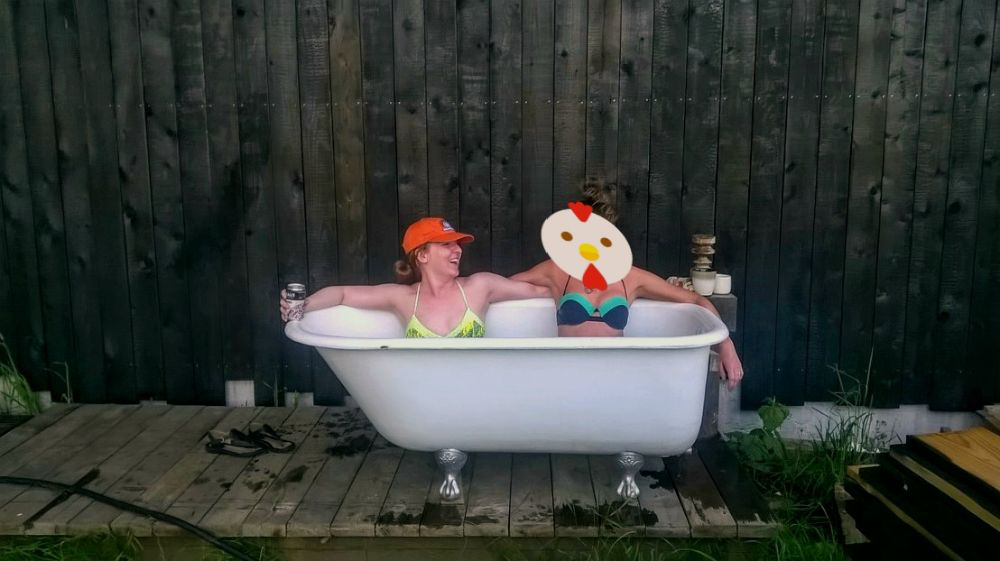

In [76]:
Image.open('data/tawkify/train/989651.jpg')